# Air quality project

## Project and data description

### Data

The dataset consists of air quality data (the concentrations of particulate matter PM1, PM2.5 and PM10, temperature, air pressure and humidity) from 2017 generated by network of 56 low-cost sensors located in Krakow, Poland. 

The data is divided into 12 files- one for each month. Each row represents a single measurement. Each column shows measured amount:

- date and time in UTC (Coordinated Universal Time) 

As Krakow, Poland is located in UTC+1 (in winter) and UTC+2 (in summer) final forecas should take under consideration this difference.  

- temperature

Air temperature measured in Celcius degrees- standard temprerature unit for Poland

- humidity

Current air humidity presented in percentages 

- pressure

Current air pressure presented in Pascals. May require conversion to hectopascals as it is a common unit for presenting air pressure value for forecast



Next, we can find three columns with measured particular matter in 3 cattegories- each in separate column:  

- pm10

Current value of particulate matter with size less than 10 μm (micrometre). 

According to norms set by Chief Inspectorate of Environmental Protection (Główny Inspektorat Ochrony Środowiska- GIOŚ) the daily average concentrations of PM10 should not exceed 50 micrograms per cubic meter. 

- pm25

Amount of particulate matter with size less than 2.5 μm.  

According to norms set by GIOŚ the daily average concentrations of PM2.5 should not exceed 25 micrograms per cubic meter. 

- pm1

Measured level of particulate matter with size less than 1 μm. 

The allowable concentration for pm1 has not been defined.


The source of particulate matter in air are various kinds of combustion ex. domestic boiler rooms or even barbecues. As research of Chief Inspectorate of Environmental Protection (Główny Inspektorat Ochrony Środowiska- GIOŚ) shows that, main source of this kind of air poluttion are low quality domestic heating stoves. Particular matter can easily penetrate from lungs to bloodstream. The smaller the particle, the more dangerous it is, as it can enter the bloodstream more easily. 

Each column name (except 'UTC time') has numeric prefix. The prefix is sensor id. For example in column named '140_humidity' we can find air humidity mesured by sensor number 140. 

There are 56 sensors, so as a result we get 337 columns (56 times 6 features + one UTC time column). 

### The goal

The goal of a project is to verify the possibility of building a model for forecasting the amount of particulate matter pm1 based on prior mesurements. Possibly the model could also predict pm2.5 and pm10. 

## Preprocessing and analysis

### Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import folium
import random
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
#import matplotlib.pyplot as plt

### Uploading and transforming the data

The data are in separated 12 files- each for one month. We're uploading all files to one dataframe. 

In [2]:
# used if we have already files locally on our machine
def create_data_frame(path_to_files, file_name_end):
    all_data = []
    all_files = glob.glob(os.path.join(path_to_files, file_name_end))
    print(all_files)
    for path in all_files:
        frame = pd.read_csv(path)
        all_data.append(frame)
    
    df = pd.concat(all_data, axis=0, ignore_index=True)
    
    return df

# root_path = r'C:\Users\User\PycharmProjects\Air_quality\Data_files'
# file_name_like = '*2017.csv'

# df = create_data_frame(root_path, file_name_like)

In [3]:
# downloading data files form github
df_01 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/january-2017.csv')
df_02 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/february-2017.csv')
df_03 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/march-2017.csv')
df_04 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/april-2017.csv')
df_05 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/may-2017.csv')
df_06 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/june-2017.csv')
df_07 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/july-2017.csv')
df_08 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/august-2017.csv')
df_09 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/september-2017.csv')
df_10 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/october-2017.csv')
df_11 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/november-2017.csv')
df_12 = pd.read_csv('https://raw.githubusercontent.com/dan-ski/Air_quality/master/Data_files/december-2017.csv')

In [4]:
all_frames = [df_01, df_02, df_03, df_04, df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12]
df = pd.concat(all_frames, axis=0, ignore_index=True)

In [5]:
df.head()

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01T02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01T03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01T04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We're sorting the data frame by 'UTC time' column.

In [6]:
def sort_by_column(frame, column_name):
    sorted_frame = frame.sort_values(by=column_name)
    sorded_frame = sorted_frame.reset_index(drop=True)
    
    return sorted_frame

In [7]:
df = sort_by_column(df, 'UTC time')
df.head()

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01T02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01T03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01T04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sensor location

To better understand the data we're creating a map with sensor locations. 

First we're uploading data frame with sensors locations (from csv file). 

In [8]:
def upload_sensor_frame(file_path):
    
    sensor_loc_path = file_path
    sensor_loc_df = pd.read_csv(sensor_loc_path)
    
    return sensor_loc_df

In [9]:
sensor_loc_path = r'C:\Users\User\PycharmProjects\Air_quality\Data_files\sensor_locations.csv'
location_frame = upload_sensor_frame(sensor_loc_path)

Now we're creating a map with markers pointing sensor location. After pointing the marker with the cursor, we can see the sensor id.  

In [10]:
def create_a_map(start_point, zoom):

    sensor_loc_map = folium.Map(
                                location=start_point,
                                zoom_start= zoom
                              )
    return sensor_loc_map

In [11]:
location=[50.057748,19.961375]
initial_zoom=12

empty_map = create_a_map(location, initial_zoom)

In [12]:
def add_markers(location_df, my_map):
    for _, sensor in location_df.iterrows():
        
        icon_color='blue'
        
        folium.Marker(location = [sensor['latitude'], sensor['longitude']],
                      tooltip=sensor['id'],
                      icon=folium.Icon(color=icon_color)
                     ).add_to(my_map)

    return my_map
        
sensor_map = add_markers(location_frame, empty_map)
sensor_map

### Data preparation

Firstly we reset the index. Next we convert UTC time values to datetime. 

In [13]:
df = df.reset_index(drop=True)

In [14]:
df['UTC time'] = pd.to_datetime(df['UTC time'])

Now basic peek into the data frame. 

In [15]:
df.head()

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8593 entries, 0 to 8592
Columns: 337 entries, UTC time to 895_pm10
dtypes: datetime64[ns](1), float64(336)
memory usage: 22.1 MB


In [17]:
df.describe()

,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
count,206.000000,206.000000,1178.000000,1235.000000,1235.000000,1235.000000,6506.000000,6506.000000,6683.000000,6631.000000,...,2653.000000,2653.000000,2653.000000,2653.000000,5443.000000,5443.000000,6337.000000,6337.000000,6337.000000,6337.000000
mean,-5.131068,74.718447,101652.880306,70.830769,75.454251,112.540891,11.464494,80.271288,101639.084842,26.537023,...,101591.979269,29.469280,31.978892,65.852997,10.660665,79.759691,101660.566672,23.879754,23.922519,41.092788
std,2.174645,9.939247,1020.704947,54.853035,66.299222,89.265573,7.630920,17.167440,653.937345,19.283222,...,809.559197,21.697085,27.709362,56.194746,7.864320,19.397843,649.831280,16.803287,20.897541,32.908029
min,-9.000000,38.000000,99160.000000,2.000000,0.000000,3.000000,-6.000000,21.000000,98374.000000,0.000000,...,98372.000000,0.000000,0.000000,0.000000,-7.000000,18.000000,98433.000000,0.000000,0.000000,0.000000
25%,-7.000000,69.000000,100828.500000,33.000000,30.000000,52.000000,6.000000,70.000000,101291.000000,13.000000,...,101116.000000,15.000000,14.000000,27.000000,4.000000,69.000000,101328.000000,13.000000,11.000000,18.000000
50%,-6.000000,77.000000,101726.000000,50.000000,52.000000,87.000000,11.000000,86.000000,101666.000000,23.000000,...,101614.000000,25.000000,25.000000,53.000000,10.000000,85.000000,101686.000000,21.000000,19.000000,33.000000
75%,-4.000000,82.000000,102352.000000,101.000000,107.500000,153.000000,17.000000,93.000000,102064.000000,34.000000,...,102207.000000,37.000000,41.000000,85.000000,16.000000,92.000000,102079.000000,29.000000,30.000000,54.000000
max,2.000000,92.000000,103619.000000,249.000000,314.000000,440.000000,37.000000,115.000000,103155.000000,160.000000,...,103146.000000,151.000000,190.000000,373.000000,34.000000,134.000000,103199.000000,132.000000,159.000000,239.000000


Having data from all sensors in one data frame makes it difficult to analyze. We decide to spread data from each sensor to separate data frame. 

There has not beed provided separate frame or column with sensor ids, so we're extracting them from column names. 

In [18]:
def get_sensor_ids(data_frame):
    sensor_ids=[]
    for column in data_frame.columns:
        id = column.partition('_')[0]
        if id.isdigit():
            id = int(id)
            sensor_ids.append(id)
    ids = set(sensor_ids)
    ids = list(ids)
    # ids.sort()
    return ids

We're saving them in 'sensor_ids' list. 

In [19]:
sensor_ids = get_sensor_ids(df)

Alter that we create a dictionary with data frames for every sensor. Sensor id i a dictionary key.

In [20]:
def create_sensor_frame(all_sensors_frame, sensor_id):
    sensor_id = str(sensor_id)
    sensor_frame = all_sensors_frame.loc[:,all_sensors_frame.columns.str.startswith(sensor_id)]
    id_series = pd.Series(int(sensor_id), name='sensor_id', index=range(len(all_sensors_frame['UTC time'])))
    sensor_frame = pd.concat([id_series, all_sensors_frame['UTC time'], sensor_frame], axis=1)
    return sensor_frame

In [21]:
def all_sensor_dict(all_data_frame, sensor_list):
    frame_dictionary = {}
    for sensor_id in sensor_list:
        frame_dictionary[sensor_id] = create_sensor_frame(all_data_frame, sensor_id)
    return frame_dictionary

In [22]:
sensor_dict = all_sensor_dict(df, sensor_ids)

## Data analysis

### Repleacing nans.

Firstly we take a general look into each sensor frame.

In [23]:
for sensor_id in sensor_dict:
    sensor_dict[sensor_id].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8593 entries, 0 to 8592
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sensor_id      8593 non-null   int64         
 1   UTC time       8593 non-null   datetime64[ns]
 2   3_temperature  206 non-null    float64       
 3   3_humidity     206 non-null    float64       
 4   3_pressure     1178 non-null   float64       
 5   3_pm1          1235 non-null   float64       
 6   3_pm25         1235 non-null   float64       
 7   3_pm10         1235 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 537.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8593 entries, 0 to 8592
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   sensor_id        8593 non-null   int64         
 1   UTC time         8593 non-null   datetime64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8593 entries, 0 to 8592
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   sensor_id        8593 non-null   int64         
 1   UTC time         8593 non-null   datetime64[ns]
 2   189_temperature  8462 non-null   float64       
 3   189_humidity     8460 non-null   float64       
 4   189_pressure     8437 non-null   float64       
 5   189_pm1          8461 non-null   float64       
 6   189_pm25         8462 non-null   float64       
 7   189_pm10         8462 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 537.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8593 entries, 0 to 8592
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   sensor_id        8593 non-null   int64         
 1   UTC time         8593 n

It seems that many sensors has missing values. We start by identifying the ratio of nans in each column. 

In [24]:
def nans_ratio(sensor_dictionary):
    print('Liczba brakujących wartości w poszczególnych kolumnach:')
    for data_frame in sensor_dictionary:
        column_names = sensor_dictionary[data_frame].columns
        for column in column_names:
            nan_ratio = ((sensor_dictionary[data_frame][column].isnull().sum())/len(sensor_dictionary[data_frame][column])).round(2) 
            print(column,': ', nan_ratio)

In [25]:
nans_ratio(sensor_dict)

Liczba brakujących wartości w poszczególnych kolumnach:
sensor_id :  0.0
UTC time :  0.0
3_temperature :  0.98
3_humidity :  0.98
3_pressure :  0.86
3_pm1 :  0.86
3_pm25 :  0.86
3_pm10 :  0.86
sensor_id :  0.0
UTC time :  0.0
263_temperature :  0.02
263_humidity :  0.02
263_pressure :  0.02
263_pm1 :  0.02
263_pm25 :  0.02
263_pm10 :  0.02
sensor_id :  0.0
UTC time :  0.0
140_temperature :  0.24
140_humidity :  0.24
140_pressure :  0.22
140_pm1 :  0.23
140_pm25 :  0.23
140_pm10 :  0.23
sensor_id :  0.0
UTC time :  0.0
142_temperature :  0.76
142_humidity :  0.76
142_pressure :  0.76
142_pm1 :  0.77
142_pm25 :  0.77
142_pm10 :  0.77
sensor_id :  0.0
UTC time :  0.0
147_temperature :  0.73
147_humidity :  0.73
147_pressure :  0.08
147_pm1 :  0.07
147_pm25 :  0.07
147_pm10 :  0.07
sensor_id :  0.0
UTC time :  0.0
808_temperature :  0.87
808_humidity :  0.87
808_pressure :  0.87
808_pm1 :  0.87
808_pm25 :  0.87
808_pm10 :  0.87
sensor_id :  0.0
UTC time :  0.0
169_temperature :  0.04
169_h

We can see that ratios can vary from nearly 0 to nearly 100. To handle such diversity in the amount of nans, we decide to split the process into few steps. 

We start from selecting the columns where missing data exceed 45%. 

In [26]:
def high_nans_ratio(sensor_dictionary):
    for data_frame in sensor_dictionary:
        column_names = sensor_dictionary[data_frame].columns
        for column in column_names:
            nan_ratio = ((sensor_dictionary[data_frame][column].isnull().sum())/len(sensor_dictionary[data_frame][column])).round(2) 
            if nan_ratio > 0.45:
                print(column,': ', nan_ratio)

In [27]:
high_nans_ratio(sensor_dict)

3_temperature :  0.98
3_humidity :  0.98
3_pressure :  0.86
3_pm1 :  0.86
3_pm25 :  0.86
3_pm10 :  0.86
142_temperature :  0.76
142_humidity :  0.76
142_pressure :  0.76
142_pm1 :  0.77
142_pm25 :  0.77
142_pm10 :  0.77
147_temperature :  0.73
147_humidity :  0.73
808_temperature :  0.87
808_humidity :  0.87
808_pressure :  0.87
808_pm1 :  0.87
808_pm25 :  0.87
808_pm10 :  0.87
172_temperature :  0.81
172_humidity :  0.81
176_pressure :  0.8
178_temperature :  0.77
178_humidity :  0.77
178_pressure :  1.0
178_pm1 :  0.77
178_pm25 :  0.77
178_pm10 :  0.77
179_pressure :  0.82
180_pressure :  0.8
181_pressure :  0.8
182_pressure :  0.8
183_pressure :  0.89
184_pressure :  0.8
185_pressure :  0.83
187_temperature :  0.72
187_humidity :  0.72
187_pressure :  0.72
187_pm1 :  0.72
187_pm25 :  0.72
187_pm10 :  0.72
196_pressure :  0.8
201_pressure :  0.8
203_pressure :  1.0
205_temperature :  0.71
205_humidity :  0.71
205_pressure :  0.84
205_pm1 :  0.71
205_pm25 :  0.71
205_pm10 :  0.71
713_

We can see that, there are sensors where there are more than 45% lack of data in every column. Completing such a large amount of data could cause problems in model training, so we decided to exclude these sensors from further analysis. 

In [28]:
def high_nans_removal(data_frame_dict):
    dropped_frames_miss_6 = {}
    new_data_frame_dict = {}
    for dict_key in sensor_dict:
        n_missing_cols = (sensor_dict[dict_key].isna().sum() / len(sensor_dict[dict_key]) > 0.45).sum()
        
        if n_missing_cols == 6:
            dropped_frames_miss_6[dict_key]=sensor_dict[dict_key]
        else:
            new_data_frame_dict[dict_key]=sensor_dict[dict_key]
            
    return new_data_frame_dict, dropped_frames_miss_6

In [29]:
new_sensor_dict, dropped_frames = high_nans_removal(sensor_dict)

After excluding sensors with insuficient amount of data, we check if there are any columns with lack of data exceeding 45% left. 

In [30]:
high_nans_ratio(new_sensor_dict)

147_temperature :  0.73
147_humidity :  0.73
172_temperature :  0.81
172_humidity :  0.81
176_pressure :  0.8
179_pressure :  0.82
180_pressure :  0.8
181_pressure :  0.8
182_pressure :  0.8
183_pressure :  0.89
184_pressure :  0.8
185_pressure :  0.83
196_pressure :  0.8
201_pressure :  0.8
203_pressure :  1.0


There are still columns with high nan ratios, however there are columns for temperature, humidity and pressure. This features do not change drasticly in small geographical areas, so we decide to complete the data with measurements from other sensor. We choose sensor to take data from based on geographical proximity and neighbourhood similarity. We also need to avoid using the same sensor twice, or extracting data from excluded sensors. 

In [31]:
new_sensor_dict[172]['172_temperature'] = new_sensor_dict[170]['170_temperature']

In [32]:
new_sensor_dict[172]['172_humidity'] = new_sensor_dict[170]['170_humidity']

In [33]:
new_sensor_dict[196]['196_pressure'].isna().sum()

6863

In [34]:
new_sensor_dict[196]['196_pressure'] = new_sensor_dict[214]['214_pressure']

In [35]:
new_sensor_dict[196]['196_pressure'].isna().sum()

67

In [36]:
new_sensor_dict[180]['180_pressure'].isna().sum()

6855

In [37]:
new_sensor_dict[180]['180_pressure'] = new_sensor_dict[223]['223_pressure']

In [38]:
new_sensor_dict[180]['180_pressure'].isna().sum()

116

In [39]:
new_sensor_dict[201]['201_pressure'].isna().sum()

6854

In [40]:
new_sensor_dict[201]['201_pressure'] = new_sensor_dict[196]['196_pressure']

In [41]:
new_sensor_dict[201]['201_pressure'].isna().sum()

67

In [42]:
new_sensor_dict[179]['179_pressure'].isna().sum()

7020

In [43]:
new_sensor_dict[179]['179_pressure'] = new_sensor_dict[220]['220_pressure']

In [44]:
new_sensor_dict[179]['179_pressure'].isna().sum()

57

In [45]:
new_sensor_dict[147]['147_temperature'].isna().sum()

6292

In [46]:
new_sensor_dict[147]['147_humidity'].isna().sum()

6294

In [47]:
new_sensor_dict[147]['147_temperature'] = new_sensor_dict[189]['189_temperature']
new_sensor_dict[147]['147_humidity'] = new_sensor_dict[189]['189_humidity']

In [48]:
new_sensor_dict[147]['147_temperature'].isna().sum(), new_sensor_dict[147]['147_humidity'].isna().sum()

(131, 133)

In [49]:
new_sensor_dict[184]['184_pressure'].isna().sum()

6860

In [50]:
new_sensor_dict[184]['184_pressure'] = new_sensor_dict[173]['173_pressure']

In [51]:
new_sensor_dict[184]['184_pressure'].isna().sum()

119

In [52]:
new_sensor_dict[182]['182_pressure'].isna().sum()

6892

In [53]:
new_sensor_dict[182]['182_pressure'] = new_sensor_dict[180]['180_pressure']

In [54]:
new_sensor_dict[182]['182_pressure'].isna().sum()

116

In [55]:
new_sensor_dict[176]['176_pressure'].isna().sum()

6854

In [56]:
new_sensor_dict[176]['176_pressure'] = new_sensor_dict[147]['147_pressure']

In [57]:
new_sensor_dict[176]['176_pressure'].isna().sum()

653

In [58]:
new_sensor_dict[183]['183_pressure'].isna().sum()

7639

In [59]:
new_sensor_dict[183]['183_pressure'] = new_sensor_dict[209]['209_pressure']

In [60]:
new_sensor_dict[183]['183_pressure'].isna().sum()

792

In [61]:
new_sensor_dict[181]['181_pressure'].isna().sum()

6859

In [62]:
new_sensor_dict[181]['181_pressure'] = new_sensor_dict[204]['204_pressure']

In [63]:
new_sensor_dict[181]['181_pressure'].isna().sum()

77

In [64]:
new_sensor_dict[203]['203_pressure'].isna().sum()

8593

In [65]:
new_sensor_dict[203]['203_pressure'] = new_sensor_dict[194]['194_pressure']

In [66]:
new_sensor_dict[203]['203_pressure'].isna().sum()

288

In [67]:
new_sensor_dict[185]['185_pressure'].isna().sum()

7135

In [68]:
new_sensor_dict[185]['185_pressure'] = new_sensor_dict[192]['192_pressure']

In [69]:
new_sensor_dict[185]['185_pressure'].isna().sum()

234

As a next step we search the columns with nan ratio above 10 %. 

In [70]:
def nans_ratio_above_10proc(sensor_dictionary):
    above_10_proc_cols = []
    for data_frame in sensor_dictionary:
        column_names = sensor_dictionary[data_frame].columns
        for column in column_names:
            nan_ratio = ((sensor_dictionary[data_frame][column].isnull().sum())/len(sensor_dictionary[data_frame][column])).round(2) 
            if nan_ratio > 0.1:
                print(column,': ', nan_ratio)
                above_10_proc_cols.append(column)
    return above_10_proc_cols

In [71]:
above_10_proc = nans_ratio_above_10proc(new_sensor_dict)

140_temperature :  0.24
140_humidity :  0.24
140_pressure :  0.22
140_pm1 :  0.23
140_pm25 :  0.23
140_pm10 :  0.23
174_temperature :  0.14
174_humidity :  0.14
174_pressure :  0.14
174_pm1 :  0.14
174_pm25 :  0.14
174_pm10 :  0.14
177_pressure :  0.35
182_temperature :  0.12
182_humidity :  0.12
182_pm1 :  0.12
182_pm25 :  0.12
182_pm10 :  0.12
195_temperature :  0.15
195_humidity :  0.15
195_pressure :  0.16
195_pm1 :  0.15
195_pm25 :  0.15
195_pm10 :  0.15
203_temperature :  0.18
203_humidity :  0.18
203_pm1 :  0.18
203_pm25 :  0.18
203_pm10 :  0.18
622_temperature :  0.38
622_humidity :  0.38
622_pressure :  0.35
622_pm1 :  0.35
622_pm25 :  0.35
622_pm10 :  0.35
895_temperature :  0.37
895_humidity :  0.37
895_pressure :  0.26
895_pm1 :  0.26
895_pm25 :  0.26
895_pm10 :  0.26


The insuficient data may appear in long time periods or it may be lack in partitular hour during the day, for example the could be lack of two hours every day. To check the structure, we we are going to plot the data. 

<AxesSubplot: xlabel='UTC time', ylabel='140_pm1'>

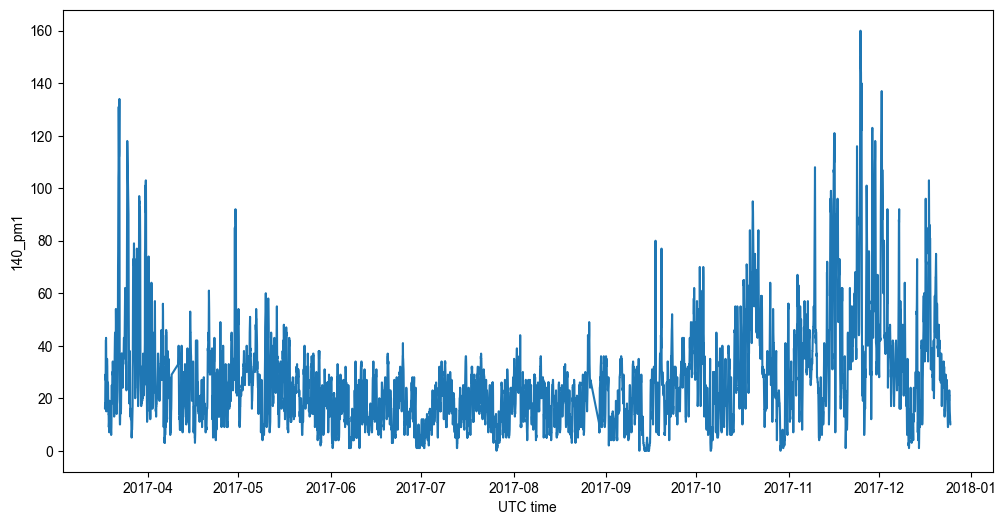

In [72]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.lineplot(x='UTC time', 
             y='140_pm1', 
             data=new_sensor_dict[140] 
             )

From the plot we can see, that data starts somewhere in march. We're going to check, when exacly measurements starts.  

In [73]:
def get_valid_indexes(data_frame):
    first_valid_indexes = {}
    first_valid_dates = {}
    for column in data_frame.columns:
        if column[:3].isdigit():
            valid_index = data_frame[column].first_valid_index()
            first_valid_indexes[column] = valid_index
            valid_date = data_frame.iloc[valid_index]['UTC time']
            first_valid_dates[column] = valid_date
    valid_indexes = pd.Series(first_valid_indexes, name='first_valid_index')
    valid_dates = pd.Series(first_valid_dates, name='datetime_of_index')
    valid_index_frame = pd.concat([valid_indexes, valid_dates], axis=1)
    return valid_index_frame

In [74]:
valid_index_df_140 = get_valid_indexes(new_sensor_dict[140])

In [75]:
valid_index_df_140

,first_valid_index,datetime_of_index
140_temperature,1811,2017-03-17 11:00:00
140_humidity,1811,2017-03-17 11:00:00
140_pressure,1811,2017-03-17 11:00:00
140_pm1,1811,2017-03-17 11:00:00
140_pm25,1811,2017-03-17 11:00:00
140_pm10,1811,2017-03-17 11:00:00


In the created data frame we can see, that all mesurements start 2017-03-17. We can also notice, it's now just none feature, but all measurements start 2017-03-17. The gap is significant. Moreover, tha data shows seasonality, and in the case of pm measurements, it changes from one sensor to another. For this reasons we decided to **exclude sensor no 140** from future analysis.

Next on our list in sensor no 174. The previous results shows 14% nan ratio in every column. 

<AxesSubplot: xlabel='UTC time', ylabel='174_pm1'>

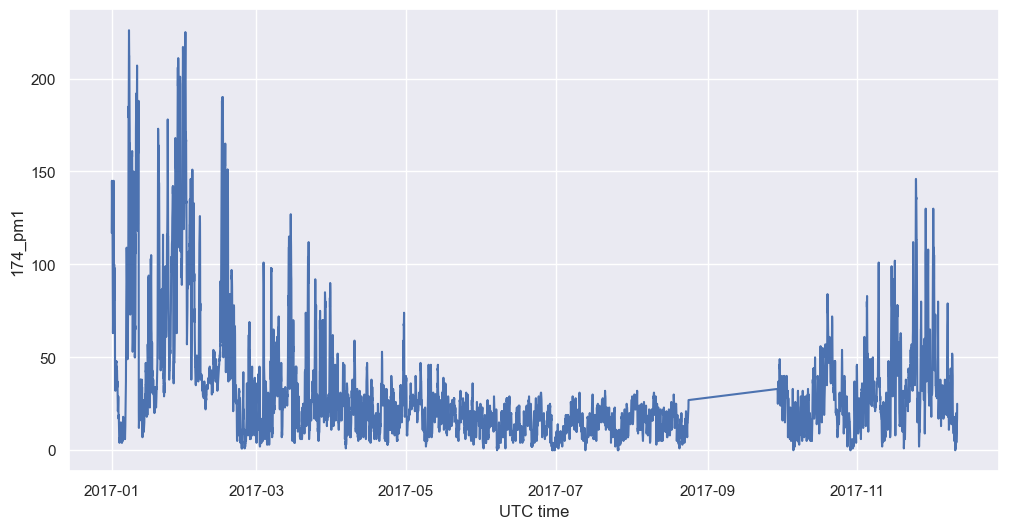

In [76]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='174_pm1', 
             data=new_sensor_dict[174] 
             )

In [77]:
get_valid_indexes(new_sensor_dict[174])

,first_valid_index,datetime_of_index
174_temperature,0,2017-01-01
174_humidity,0,2017-01-01
174_pressure,0,2017-01-01
174_pm1,0,2017-01-01
174_pm25,0,2017-01-01
174_pm10,0,2017-01-01


We can notice that data starts, as is should, from 2022-01-01. The gap starts around august. We going to examine this case.

<AxesSubplot: xlabel='UTC time', ylabel='174_pm1'>

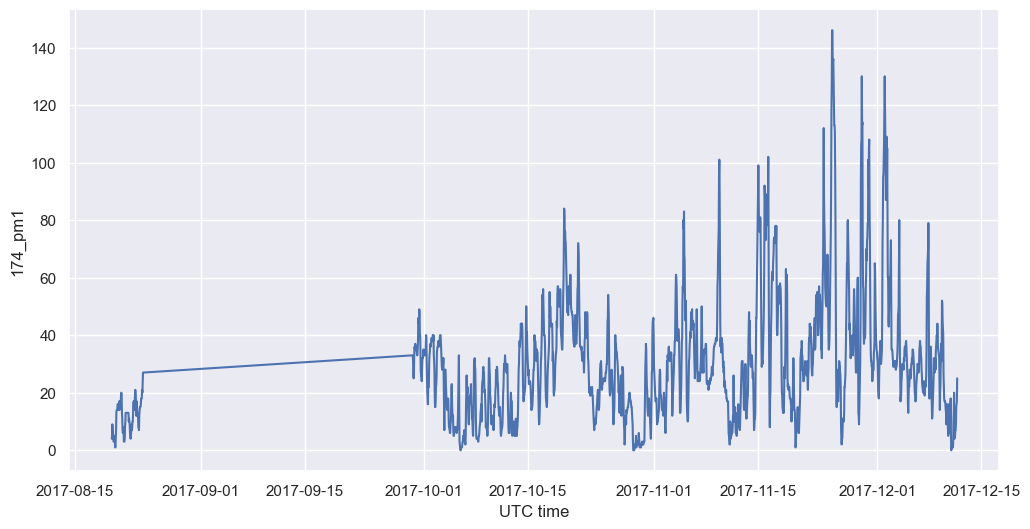

In [78]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='174_pm1', 
             data=new_sensor_dict[174].iloc[5544:]
             )

The gap starts in 2017-08-24 and couninous till 2019-09-29. Another one begins in 2017-12-11 adn ends in 2017-12-25. To save the rest of the data, and to maintain data continuity, we raplace the missing values with equivalents from nerby sensor. 

In [79]:
# period from 2017-08-24 to 2019-09-29
new_sensor_dict[174].iloc[5646:6514] = new_sensor_dict[204].iloc[5646:6514]

In [80]:
# period from 2017-12-11 to 2017-12-25
new_sensor_dict[174].iloc[8275:8592] = new_sensor_dict[204].iloc[8275:8592]

After the replacement we can see, that the data is continuous. 

<AxesSubplot: xlabel='UTC time', ylabel='174_pm1'>

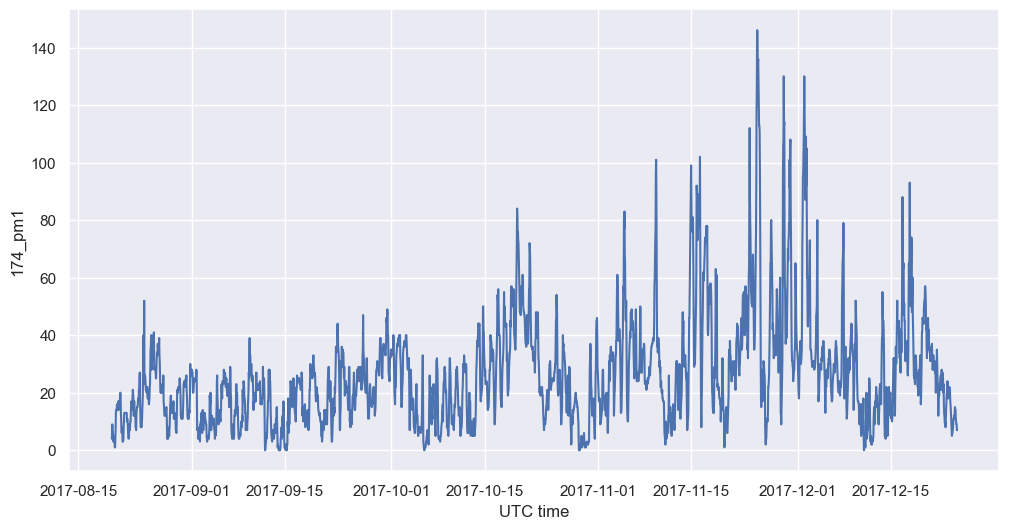

In [81]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='174_pm1', 
             data=new_sensor_dict[174].iloc[5544:]
             )

In [82]:
# displaying any row which has NaN value
new_sensor_dict[174][new_sensor_dict[174].isna().any(axis=1)]

,sensor_id,UTC time,174_temperature,174_humidity,174_pressure,174_pm1,174_pm25,174_pm10
113,174,2017-01-05 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN
114,174,2017-01-05 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
115,174,2017-01-05 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN
116,174,2017-01-05 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN
117,174,2017-01-05 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN
118,174,2017-01-05 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1189,174,2017-02-19 13:00:00,4.0,78.0,NaN,21.0,18.0,31.0
1190,174,2017-02-19 14:00:00,3.0,78.0,NaN,29.0,27.0,47.0
1191,174,2017-02-19 15:00:00,4.0,78.0,NaN,32.0,31.0,53.0
1192,174,2017-02-19 16:00:00,3.0,76.0,NaN,34.0,33.0,56.0


Now, the ratio of nans is below 10 %. The rest of nans is going to be filled in further steps, together with nans with other sensors

In the data from sensor no 177 we can see 35 % of nans in pressure. 

<AxesSubplot: xlabel='UTC time', ylabel='177_pressure'>

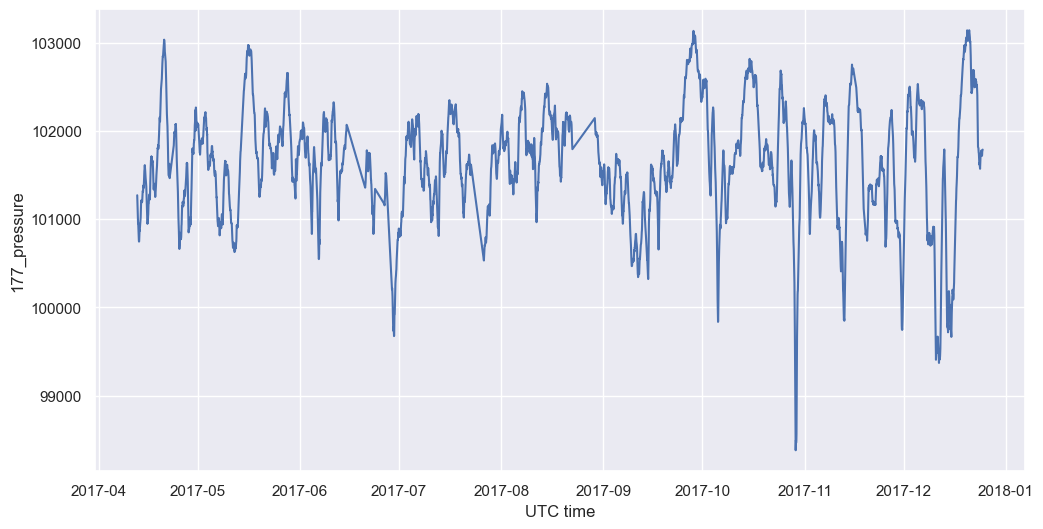

In [83]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='177_pressure', 
             data=new_sensor_dict[177]
             )

In [84]:
get_valid_indexes(new_sensor_dict[177])

,first_valid_index,datetime_of_index
177_temperature,0,2017-01-01 00:00:00
177_humidity,0,2017-01-01 00:00:00
177_pressure,2439,2017-04-12 15:00:00
177_pm1,0,2017-01-01 00:00:00
177_pm25,0,2017-01-01 00:00:00
177_pm10,0,2017-01-01 00:00:00


We can see that first valid measurement of pressure appears in 2017-04-12. The lack of data seems serious, but the pressure is not a value, which changes remarkably within the city borders, this is why we are going to copy pressure measurements form nearby sensor- no 205. 

In [85]:
new_sensor_dict[177].loc[:2439, '177_pressure'] = new_sensor_dict[204].loc[:2439,'204_pressure']

<AxesSubplot: xlabel='UTC time', ylabel='177_pressure'>

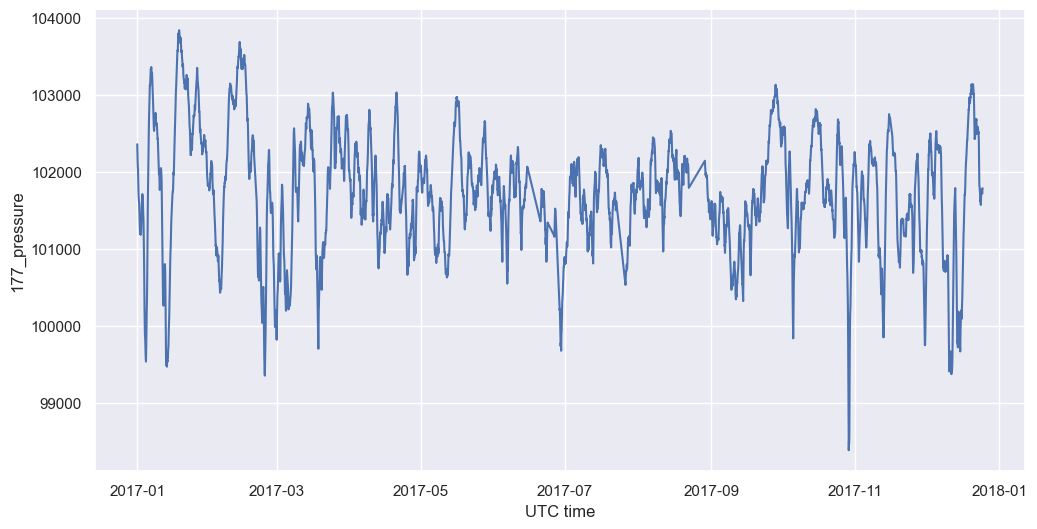

In [86]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='177_pressure', 
             data=new_sensor_dict[177]
             )

The missing values are filled with data fram sensor no 204.

There is also 12% missing data in every column, except air pressure, in data from sensor no 182. 

In [87]:
get_valid_indexes(new_sensor_dict[182])

,first_valid_index,datetime_of_index
182_temperature,0,2017-01-01
182_humidity,0,2017-01-01
182_pressure,0,2017-01-01
182_pm1,0,2017-01-01
182_pm25,0,2017-01-01
182_pm10,0,2017-01-01


We can see, the data starts as it should- 1st of January. 

<AxesSubplot: xlabel='UTC time', ylabel='182_pm1'>

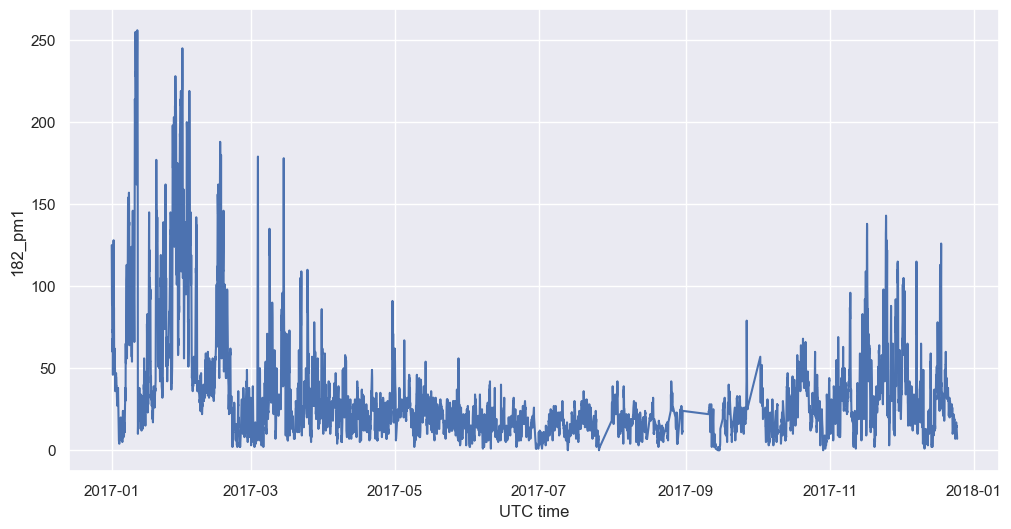

In [88]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='182_pm1', 
             data=new_sensor_dict[182]
             )

In [89]:
new_sensor_dict[182].head()

,sensor_id,UTC time,182_temperature,182_humidity,182_pressure,182_pm1,182_pm25,182_pm10
0,182,2017-01-01 00:00:00,0.0,54.0,102429.0,125.0,145.0,227.0
1,182,2017-01-01 01:00:00,0.0,53.0,102381.0,106.0,122.0,192.0
2,182,2017-01-01 02:00:00,0.0,52.0,102300.0,94.0,106.0,169.0
3,182,2017-01-01 03:00:00,0.0,51.0,102247.0,89.0,100.0,158.0
4,182,2017-01-01 04:00:00,0.0,51.0,102204.0,89.0,100.0,159.0


First gap

In [90]:
new_sensor_dict[182].loc[4961:5079,'182_temperature'] = new_sensor_dict[180].loc[4961:5079,'180_temperature']

In [91]:
new_sensor_dict[182].loc[4961:5079,'182_humidity'] = new_sensor_dict[180].loc[4961:5079,'180_humidity']

In [92]:
new_sensor_dict[182].loc[4961:5079,'182_pressure'] = new_sensor_dict[180].loc[4961:5079,'180_pressure']

In [93]:
new_sensor_dict[182].loc[4961:5079,'182_pm1'] = new_sensor_dict[180].loc[4961:5079,'180_pm1']

In [94]:
new_sensor_dict[182].loc[4961:5079,'182_pm25'] = new_sensor_dict[180].loc[4961:5079,'180_pm25']

In [95]:
new_sensor_dict[182].loc[4961:5079,'182_pm10'] = new_sensor_dict[180].loc[4961:5079,'180_pm10']

Second gap

In [96]:
new_sensor_dict[182].loc[5442:5466,'182_temperature'] = new_sensor_dict[180].loc[5442:5466,'180_temperature']

In [97]:
new_sensor_dict[182].loc[5442:5466,'182_humidity'] = new_sensor_dict[180].loc[5442:5466,'180_humidity']

In [98]:
new_sensor_dict[182].loc[5442:5466,'182_pressure'] = new_sensor_dict[180].loc[5442:5466,'180_pressure']

In [99]:
new_sensor_dict[182].loc[5442:5466,'182_pm1'] = new_sensor_dict[180].loc[5442:5466,'180_pm1']

In [100]:
new_sensor_dict[182].loc[5442:5466,'182_pm25'] = new_sensor_dict[180].loc[5442:5466,'180_pm25']

In [101]:
new_sensor_dict[182].loc[5442:5466,'182_pm10'] = new_sensor_dict[180].loc[5442:5466,'180_pm10']

Third gap

In [102]:
new_sensor_dict[182].loc[5803:6065,'182_temperature'] = new_sensor_dict[180].loc[5803:6065,'180_temperature']

In [103]:
new_sensor_dict[182].loc[5803:6065,'182_humidity'] = new_sensor_dict[180].loc[5803:6065,'180_humidity']

In [104]:
new_sensor_dict[182].loc[5803:6065,'182_pressure'] = new_sensor_dict[180].loc[5803:6065,'180_pressure']

In [105]:
new_sensor_dict[182].loc[5803:6065,'182_pm1'] = new_sensor_dict[180].loc[5803:6065,'180_pm1']

In [106]:
new_sensor_dict[182].loc[5803:6065,'182_pm25'] = new_sensor_dict[180].loc[5803:6065,'180_pm25']

In [107]:
new_sensor_dict[182].loc[5803:6065,'182_pm10'] = new_sensor_dict[180].loc[5803:6065,'180_pm10']

Fourth gap

In [108]:
new_sensor_dict[182].loc[6464:6590,'182_temperature'] = new_sensor_dict[180].loc[6464:6590,'180_temperature']

In [109]:
new_sensor_dict[182].loc[6464:6590,'182_humidity'] = new_sensor_dict[180].loc[6464:6590,'180_humidity']

In [110]:
new_sensor_dict[182].loc[6464:6590,'182_pressure'] = new_sensor_dict[180].loc[6464:6590,'180_pressure']

In [111]:
new_sensor_dict[182].loc[6464:6590,'182_pm1'] = new_sensor_dict[180].loc[6464:6590,'180_pm1']

In [112]:
new_sensor_dict[182].loc[6464:6590,'182_pm25'] = new_sensor_dict[180].loc[6464:6590,'180_pm25']

In [113]:
new_sensor_dict[182].loc[6464:6590,'182_pm10'] = new_sensor_dict[180].loc[6464:6590,'180_pm10']

<AxesSubplot: xlabel='UTC time', ylabel='182_pm1'>

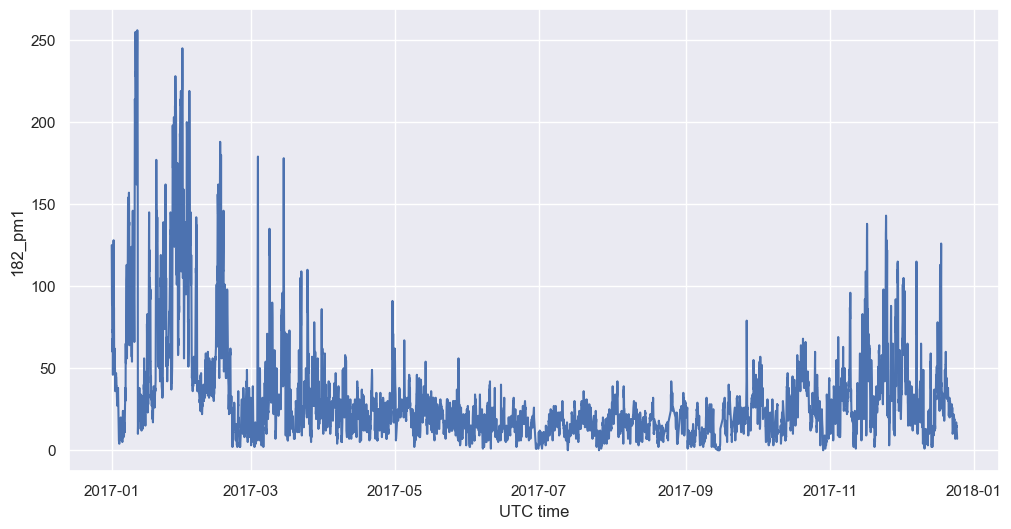

In [114]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='182_pm1', 
             data=new_sensor_dict[182]
             )

In the sensor no 195 we can also see 15% lack of data. 

<AxesSubplot: xlabel='UTC time', ylabel='195_pm1'>

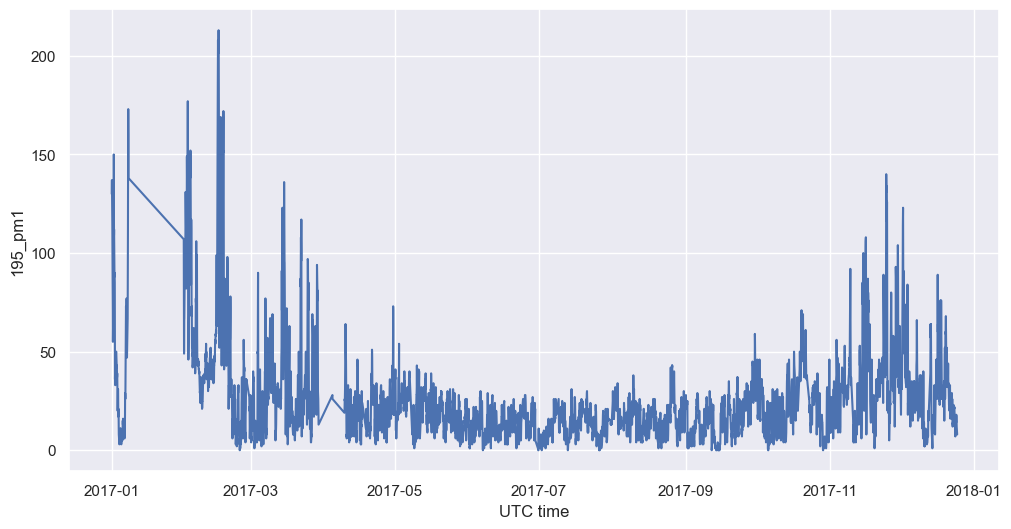

In [115]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='195_pm1', 
             data=new_sensor_dict[195]
             )

We can distinguish two gaps in data. We're going to fill it with nearby sensor data- no. 210

In [116]:
new_sensor_dict[195].loc[172:731,'195_temperature'] = new_sensor_dict[210].loc[172:731,'210_temperature']

In [117]:
new_sensor_dict[195].loc[172:731,'195_humidity'] = new_sensor_dict[210].loc[172:731,'210_humidity']

In [118]:
new_sensor_dict[195].loc[172:731,'195_pressure'] = new_sensor_dict[210].loc[172:731,'210_pressure']

In [119]:
new_sensor_dict[195].loc[172:731,'195_pm1'] = new_sensor_dict[210].loc[172:731,'210_pm1']

In [120]:
new_sensor_dict[195].loc[172:731,'195_pm25'] = new_sensor_dict[210].loc[172:731,'210_pm25']

In [121]:
new_sensor_dict[195].loc[172:731,'195_pm10'] = new_sensor_dict[210].loc[172:731,'210_pm10']

In [122]:
new_sensor_dict[195].loc[2103:2364,'195_temperature'] = new_sensor_dict[210].loc[2103:2364,'210_temperature']

In [123]:
new_sensor_dict[195].loc[2103:2364,'195_humidity'] = new_sensor_dict[210].loc[2103:2364,'210_humidity']

In [124]:
new_sensor_dict[195].loc[2103:2364,'195_pressure'] = new_sensor_dict[210].loc[2103:2364,'210_pressure']

In [125]:
new_sensor_dict[195].loc[2103:2364,'195_pm1'] = new_sensor_dict[210].loc[2103:2364,'210_pm1']

In [126]:
new_sensor_dict[195].loc[2103:2364,'195_pm25'] = new_sensor_dict[210].loc[2103:2364,'210_pm25']

In [127]:
new_sensor_dict[195].loc[172:731,'195_pm10'] = new_sensor_dict[210].loc[172:731,'210_pm10']

<AxesSubplot: xlabel='UTC time', ylabel='195_pm1'>

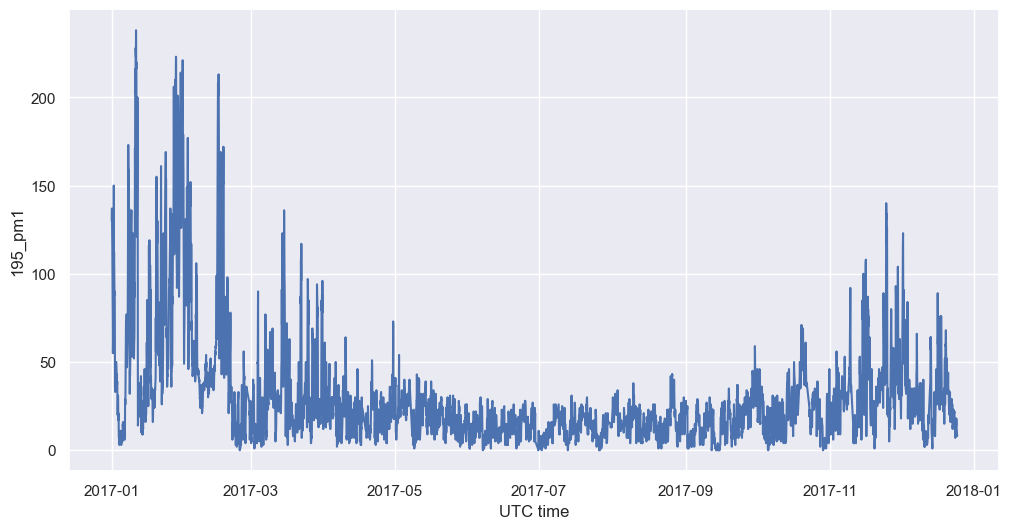

In [128]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='195_pm1', 
             data=new_sensor_dict[195]
             )

We can also notice, around 18% lack in data in sensor no 203. 

<AxesSubplot: xlabel='UTC time', ylabel='203_pm1'>

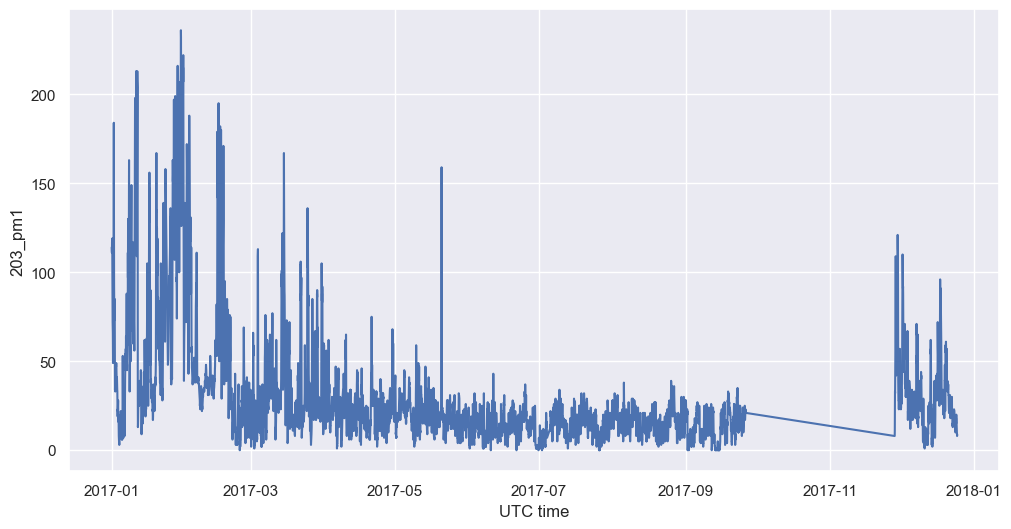

In [129]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='203_pm1', 
             data=new_sensor_dict[203]
             )

We can spot one remarkabe gap. We're going to use the same aproach as in previous sensor. 

In [130]:
new_sensor_dict[203].loc[6444:7956,'203_temperature'] = new_sensor_dict[194].loc[6444:7956,'194_temperature']

In [131]:
new_sensor_dict[203].loc[6444:7956,'203_humidity'] = new_sensor_dict[194].loc[6444:7956,'194_humidity']

In [132]:
new_sensor_dict[203].loc[6444:7956,'203_pressure'] = new_sensor_dict[194].loc[6444:7956,'194_pressure']

In [133]:
new_sensor_dict[203].loc[6444:7956,'203_pm1'] = new_sensor_dict[194].loc[6444:7956,'194_pm1']

In [134]:
new_sensor_dict[203].loc[6444:7956,'203_pm25'] = new_sensor_dict[194].loc[6444:7956,'194_pm25']

In [135]:
new_sensor_dict[203].loc[6444:7956,'203_pm10'] = new_sensor_dict[194].loc[6444:7956,'194_pm10']

<AxesSubplot: xlabel='UTC time', ylabel='203_pm1'>

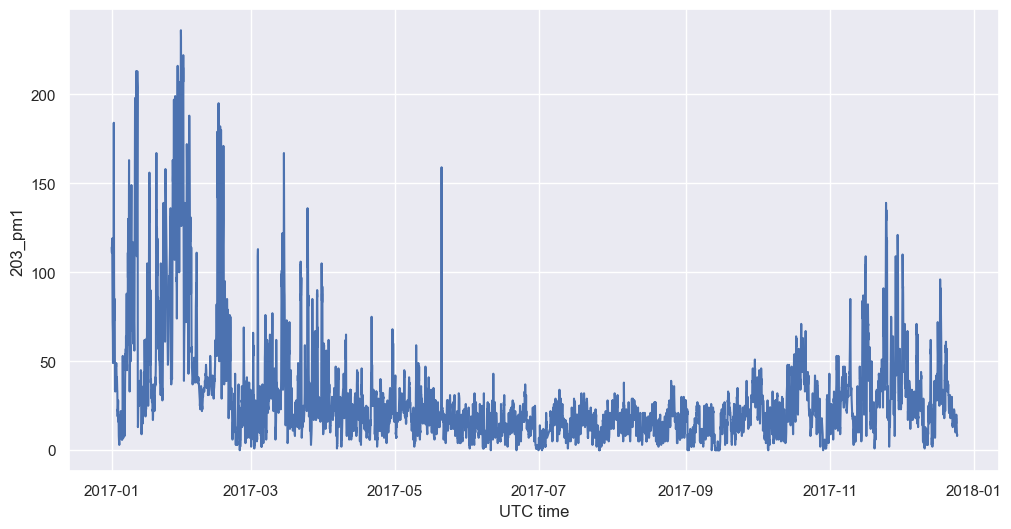

In [136]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x='UTC time', 
             y='203_pm1', 
             data=new_sensor_dict[203]
             )

In [137]:
nans_ratio_above_10proc(new_sensor_dict)

140_temperature :  0.24
140_humidity :  0.24
140_pressure :  0.22
140_pm1 :  0.23
140_pm25 :  0.23
140_pm10 :  0.23
622_temperature :  0.38
622_humidity :  0.38
622_pressure :  0.35
622_pm1 :  0.35
622_pm25 :  0.35
622_pm10 :  0.35
895_temperature :  0.37
895_humidity :  0.37
895_pressure :  0.26
895_pm1 :  0.26
895_pm25 :  0.26
895_pm10 :  0.26


['140_temperature',
 '140_humidity',
 '140_pressure',
 '140_pm1',
 '140_pm25',
 '140_pm10',
 '622_temperature',
 '622_humidity',
 '622_pressure',
 '622_pm1',
 '622_pm25',
 '622_pm10',
 '895_temperature',
 '895_humidity',
 '895_pressure',
 '895_pm1',
 '895_pm25',
 '895_pm10']

We can observe a 35-38% lack of data in each column of sensor no 622 and 26-37 % lack of data in each column of data from sensor nt 895. Filling that much data may cause problems in trainig a model, this is why we decided to exclude this sensort from future analysis. 

In [138]:
pop_140 = new_sensor_dict.pop(140)
dropped_frames[140] = pop_140

In [139]:
pop_622 = new_sensor_dict.pop(622)
dropped_frames[622] = pop_622

In [140]:
pop_895 = new_sensor_dict.pop(895)
dropped_frames[895] = pop_895

In [141]:
nans_ratio_above_10proc(new_sensor_dict)

[]

Right now, all nans ratios in every colum is lower than 10%. For the rest of the cases we are goin to replace it with previous values. For example if there is valid measurement in 2017-10-12 12:00, and missing one in 2017-10-12 13:00, we are goint to insert values from 2017-10-12 12:00 to 2017-10-12 13:00.  

In [142]:
nans_ratio(new_sensor_dict)

Liczba brakujących wartości w poszczególnych kolumnach:
sensor_id :  0.0
UTC time :  0.0
263_temperature :  0.02
263_humidity :  0.02
263_pressure :  0.02
263_pm1 :  0.02
263_pm25 :  0.02
263_pm10 :  0.02
sensor_id :  0.0
UTC time :  0.0
147_temperature :  0.02
147_humidity :  0.02
147_pressure :  0.08
147_pm1 :  0.07
147_pm25 :  0.07
147_pm10 :  0.07
sensor_id :  0.0
UTC time :  0.0
169_temperature :  0.04
169_humidity :  0.04
169_pressure :  0.04
169_pm1 :  0.04
169_pm25 :  0.04
169_pm10 :  0.04
sensor_id :  0.0
UTC time :  0.0
170_temperature :  0.02
170_humidity :  0.02
170_pressure :  0.02
170_pm1 :  0.02
170_pm25 :  0.02
170_pm10 :  0.02
sensor_id :  0.0
UTC time :  0.0
171_temperature :  0.01
171_humidity :  0.01
171_pressure :  0.01
171_pm1 :  0.01
171_pm25 :  0.01
171_pm10 :  0.01
sensor_id :  0.0
UTC time :  0.0
172_temperature :  0.02
172_humidity :  0.02
172_pressure :  0.03
172_pm1 :  0.02
172_pm25 :  0.02
172_pm10 :  0.02
sensor_id :  0.0
UTC time :  0.0
173_temperature :

In [143]:
def replace_nan_with_prev(sensor_dictionary):
    for key in sensor_dictionary:
        column_names = sensor_dictionary[key].columns
        for column in column_names:
            if column[0:3].isdigit():
                for index, value in enumerate(sensor_dictionary[key][column]):
                    float(value)
                    # if value in first row is nan take first valid value from column 
                    if np.isnan([value]) and index==0:
                        sensor_dictionary[key][column][index] = sensor_dictionary[key][column].first_valid_index()
                    elif np.isnan([value]) and index!=0:
                        prev_val = sensor_dictionary[key][column][index-1]
                        sensor_dictionary[key][column][index]=prev_val

In [144]:
def nans_number(sensor_dictionary):
    print('Liczba brakujących wartości w poszczególnych kolumnach:')
    for data_frame in sensor_dictionary:
        column_names = sensor_dictionary[data_frame].columns
        for column in column_names:
            nans_number = sensor_dictionary[data_frame][column].isnull().sum() 
            print(column,': ', nans_number)

In [145]:
replace_nan_with_prev(new_sensor_dict)

C:\Users\User\AppData\Local\Temp\ipykernel_2160\3920397619.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_dictionary[key][column][index]=prev_val
C:\Users\User\AppData\Local\Temp\ipykernel_2160\3920397619.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_dictionary[key][column][index] = sensor_dictionary[key][column].first_valid_index()


Finally, we chec if there are any NaNs left.

In [146]:
def any_nan(sensor_dictionary):
    for key in sensor_dictionary:
        print('Is there any nan in sensor no ',key,' ? ',sensor_dictionary[key].isnull().values.any())

In [147]:
any_nan(new_sensor_dict)

Is there any nan in sensor no  263  ?  False
Is there any nan in sensor no  147  ?  False
Is there any nan in sensor no  169  ?  False
Is there any nan in sensor no  170  ?  False
Is there any nan in sensor no  171  ?  False
Is there any nan in sensor no  172  ?  False
Is there any nan in sensor no  173  ?  False
Is there any nan in sensor no  174  ?  False
Is there any nan in sensor no  176  ?  False
Is there any nan in sensor no  177  ?  False
Is there any nan in sensor no  179  ?  False
Is there any nan in sensor no  180  ?  False
Is there any nan in sensor no  181  ?  False
Is there any nan in sensor no  182  ?  False
Is there any nan in sensor no  183  ?  False
Is there any nan in sensor no  184  ?  False
Is there any nan in sensor no  185  ?  False
Is there any nan in sensor no  189  ?  False
Is there any nan in sensor no  192  ?  False
Is there any nan in sensor no  194  ?  False
Is there any nan in sensor no  195  ?  False
Is there any nan in sensor no  196  ?  False
Is there a

## Data analysis

As sensor no 212 had low nan range from the begining, we are going to use it as model sensor. 

In [148]:
model_frame = (new_sensor_dict[212]).copy()

In [149]:
model_frame['month']=model_frame['UTC time'].dt.month

<AxesSubplot: xlabel='month', ylabel='212_pm1'>

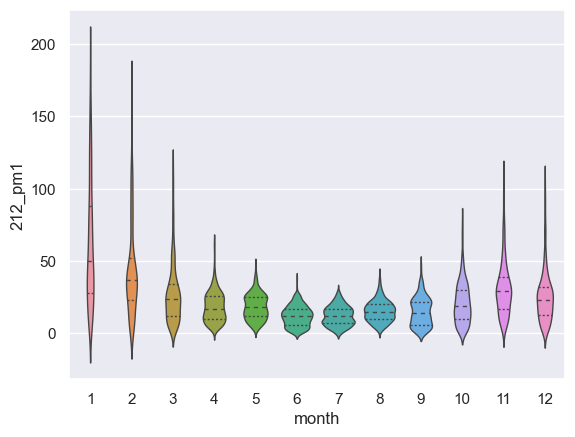

In [150]:
sns.violinplot(data=model_frame, 
               x="month", 
               y="212_pm1",
               inner="quart", 
               linewidth=1)

<AxesSubplot: xlabel='month', ylabel='212_pm1'>

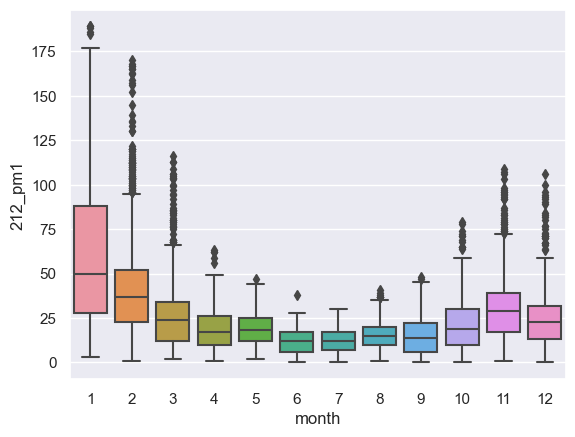

In [151]:
sns.boxplot(x='month',
               y='212_pm1',
              data= model_frame,
              whis = 1.5)

<AxesSubplot: xlabel='month', ylabel='212_pm25'>

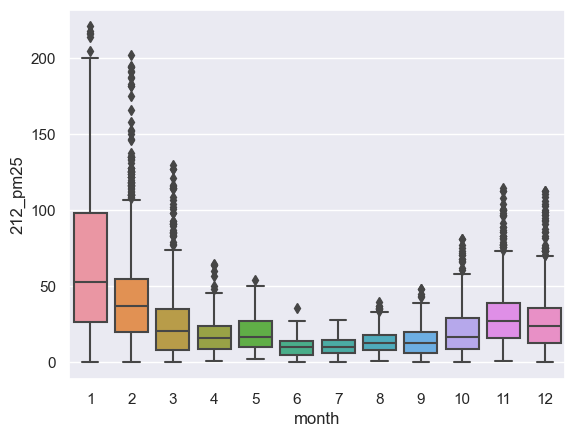

In [152]:
sns.boxplot(x='month',
               y='212_pm25',
              data= model_frame,
              whis = 1.5)

<AxesSubplot: xlabel='month', ylabel='212_pm10'>

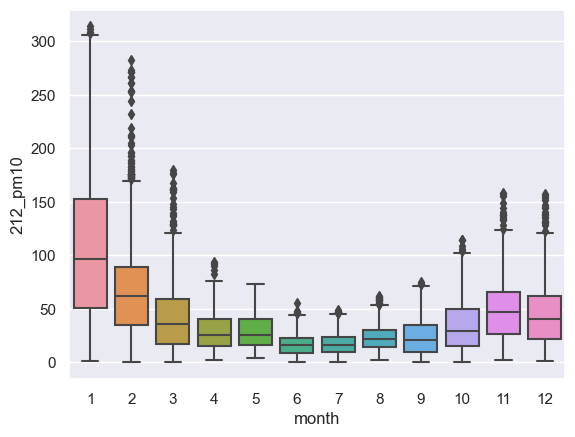

In [153]:
sns.boxplot(x='month',
               y='212_pm10',
              data= model_frame,
              whis = 1.5)

In [154]:
# def get_last_day_id(data_frame):
    
#     last_month_datetime = {1: '2017-01-31 23:00:00', 2:'2017-02-28 23:00:00', 3: '2017-03-31 23:00:00',
#                                4:'2017-04-30 23:00:00', 5:'2017-05-31 23:00:00', 6:'2017-06-30 23:00:00',  
#                                7:'2017-07-31 23:00:00', 8:'2017-08-31 23:00:00', 9:'2017-09-30 23:00:00', 
#                                10:'2017-10-31 23:00:00', 11:'2017-11-30 23:00:00', 12:'2017-12-25 00:00:00'}  
#     last_month_ids = {}
    
#     for month in last_month_datetime:
#         last_id = ((data_frame.loc[data_frame['UTC time'] == last_month_datetime[month]]).index[0])
#         last_month_ids[month] = last_id+1
       
#     return last_month_ids

# last_day_ids = get_last_day_id(model_frame)

In [155]:
# def replace_outliers_monthly(model_frame, last_day_ids, IQR_mlultiply_level=1.5):
#     for column in model_frame:
#         column_name = column.partition('_')[0]
#         if column_name.isdigit():
#             for key in last_day_ids:
#                 if key-1 == 0:
#                     Q1 = model_frame[column].iloc[:last_day_ids[key]].quantile(q=0.25)
#                     Q3 = model_frame[column].iloc[:last_day_ids[key]].quantile(q=0.75)
#                     IQR = Q3-Q1
#                     IQR_multiply = IQR*1.5
#                     model_frame[column].iloc[:last_day_ids[key]]= model_frame[column].iloc[:last_day_ids[key]].map(lambda x: x if (x < IQR_multiply) else IQR_multiply)
#                 else:  
#                     Q1 = model_frame[column].iloc[last_day_ids[key-1]:last_day_ids[key]].quantile(q=0.25)
#                     Q3 = model_frame[column].iloc[last_day_ids[key-1]:last_day_ids[key]].quantile(q=0.75)
#                     IQR = Q3-Q1
#                     IQR_multiply = IQR*IQR_mlultiply_level
#                     model_frame[column].iloc[last_day_ids[key-1]:last_day_ids[key]]= model_frame[column].iloc[last_day_ids[key-1]:last_day_ids[key]].map(lambda x: x if (x < IQR_multiply) else IQR_multiply)

We can see some outliers in the particulate matter measurements. What is interesting, the levels vary remarkably between months. For example what is an outlier in june i not an outlier in may. 

Taking this under account we replaced outliers in considering data in each month, however finally, the models performed worse after this operation. Right now the functions "get_last_day_id(data_frame)" and "replace_outliers_monthly" stay in notebook as it may be used for future development. 

We are changing pascals to hectopascals, as it's common unit for aire pressure. 

In [156]:
def pascals_to_hectopascals(sensors_dictionary):
    for key in sensors_dictionary:
        column_name = str(key) + '_pressure'
        new_sensor_dict[key][column_name] = new_sensor_dict[key][column_name]/100

In [157]:
pascals_to_hectopascals(new_sensor_dict)

In [158]:
new_sensor_dict[212]

,sensor_id,UTC time,212_temperature,212_humidity,212_pressure,212_pm1,212_pm25,212_pm10
0,212,2017-01-01 00:00:00,0.0,29.0,1014.35,107.0,123.0,196.0
1,212,2017-01-01 01:00:00,0.0,28.0,1013.87,123.0,144.0,227.0
2,212,2017-01-01 02:00:00,0.0,28.0,1013.02,120.0,140.0,224.0
3,212,2017-01-01 03:00:00,0.0,27.0,1012.50,104.0,119.0,190.0
4,212,2017-01-01 04:00:00,0.0,25.0,1012.04,88.0,100.0,161.0
...,...,...,...,...,...,...,...,...
8588,212,2017-12-24 20:00:00,6.0,77.0,1016.24,10.0,11.0,19.0
8589,212,2017-12-24 21:00:00,5.0,77.0,1016.59,9.0,10.0,18.0
8590,212,2017-12-24 22:00:00,5.0,74.0,1016.58,7.0,8.0,15.0
8591,212,2017-12-24 23:00:00,5.0,77.0,1016.49,7.0,8.0,14.0


In [159]:
new_sensor_dict[212].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8593 entries, 0 to 8592
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   sensor_id        8593 non-null   int64         
 1   UTC time         8593 non-null   datetime64[ns]
 2   212_temperature  8593 non-null   float64       
 3   212_humidity     8593 non-null   float64       
 4   212_pressure     8593 non-null   float64       
 5   212_pm1          8593 non-null   float64       
 6   212_pm25         8593 non-null   float64       
 7   212_pm10         8593 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 537.2 KB


## Training a model

### Creating test/train sets

In [160]:
df = new_sensor_dict[212]

df = df.drop(columns=('UTC time'))

dset_len = len(df)
df_train = df.iloc[0:int(dset_len*0.7)]
df_val = df.iloc[int(dset_len*0.7):int(dset_len*0.85)]
df_test = df.iloc[int(dset_len*0.85):]
 
num_features = df.shape[1]
len(df_train), len(df_val), len(df_test)

(6015, 1289, 1289)

### Standarization

In [161]:
scaler = StandardScaler()
df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)
df_val = scaler.transform(df_val)

In [162]:
df_train=pd.DataFrame(df_train, columns=df.columns)
df_test=pd.DataFrame(df_test, columns=df.columns)
df_val=pd.DataFrame(df_val, columns=df.columns)

In [163]:
# code according to tensorflow doc: https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
 
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None):
   
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [164]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [165]:
def plot(self, model=None, plot_col='212_pm1', max_subplots=3): # column to plot
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue


    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
        predictions = model(inputs)
        if len(predictions.shape) == 2:
            predictions = tf.expand_dims(predictions,1)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [166]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [167]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

We are going to predict pm10 values for the next 24 hours, based on last 72 hours

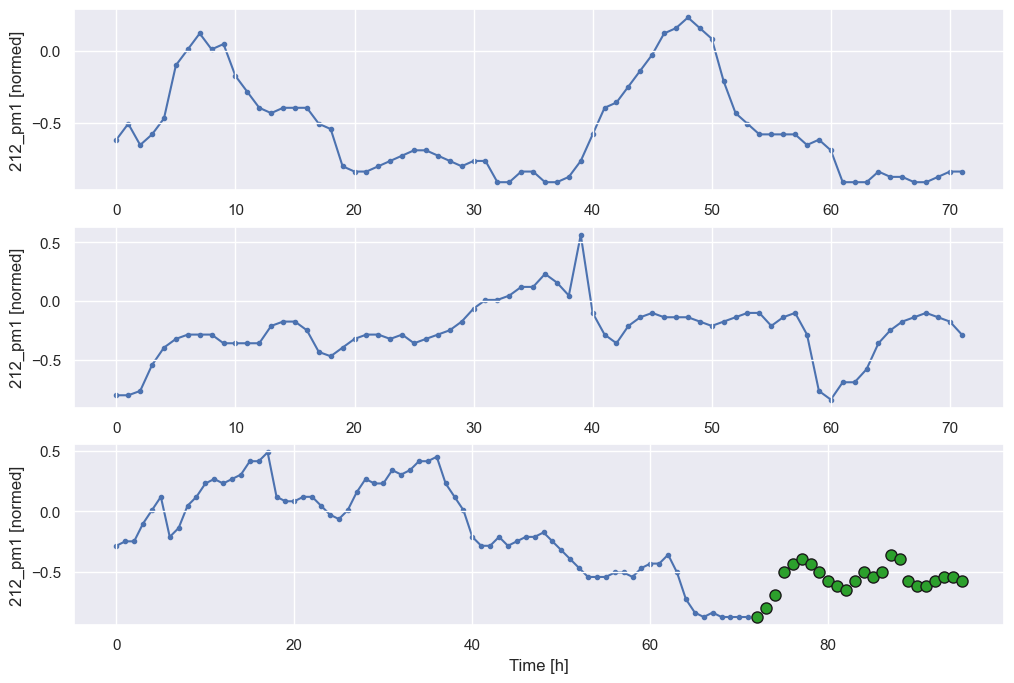

In [168]:
continous_24h = WindowGenerator(input_width=24*3, label_width=24, shift=24, label_columns=['212_pm1'])
print(continous_24h)
continous_24h.plot()

In [169]:
def train_simple_RNN(data, rnn1_units=16, rnn2_units=16, prediction_hours=24, loss_func='mse', train_epochs=20):
        
    model = keras.models.Sequential()
    rnn1 = keras.layers.SimpleRNN(rnn1_units, return_sequences=True)
    rnn2 = keras.layers.SimpleRNN(rnn2_units)
    fc = keras.layers.Dense(prediction_hours)
    
    model.add(rnn1)
    model.add(rnn2)
    model.add(fc)
    
    model.compile(optimizer='adam', loss= loss_func)
    
    history = model.fit(data.train, epochs=train_epochs, validation_data=data.val)
        
    return model, history

In [170]:
simple_rnn_model = train_simple_RNN(data=continous_24h)

Epoch 1/20
185/185 [==============================] - 5s 17ms/step - loss: 0.6960 - val_loss: 0.1510
Epoch 2/20
185/185 [==============================] - 3s 15ms/step - loss: 0.4173 - val_loss: 0.1362
Epoch 3/20
185/185 [==============================] - 3s 16ms/step - loss: 0.3610 - val_loss: 0.1405
Epoch 4/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3413 - val_loss: 0.1405
Epoch 5/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3313 - val_loss: 0.1370
Epoch 6/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3232 - val_loss: 0.1390
Epoch 7/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3184 - val_loss: 0.1426
Epoch 8/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3153 - val_loss: 0.1372
Epoch 9/20
185/185 [==============================] - 3s 18ms/step - loss: 0.3085 - val_loss: 0.1446
Epoch 10/20
185/185 [==============================] - 3s 18ms/step - loss: 0.3007 - val_lo

In [171]:
def plot_history(training_history):
        plt.plot(training_history.history['loss'], label='train loss')
        plt.plot(training_history.history['val_loss'], label='validation loss')
        plt.legend()

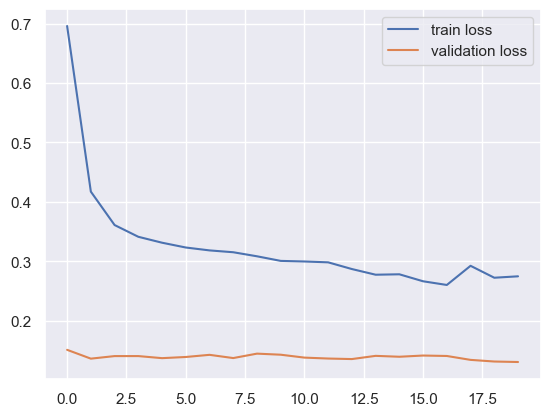

In [172]:
plot_history(simple_rnn_model[1])

In [173]:
def plot_sample_prediction_pm1(test_case, trained_model):
        test_sample_x, test_sample_y = next(iter(test_case.test))
        model_pred = trained_model.predict(test_sample_x)
        prediction = model_pred[0]
        previous = (test_sample_x[0][:,-3]).numpy().flatten()
        y_next_labels = test_sample_y[0].numpy().flatten()
        plt.plot(np.append(previous, prediction), label='predictions')
        plt.plot(np.append(previous, y_next_labels), label='true values')
        plt.legend()

1/1 [==============================] - 0s 203ms/step


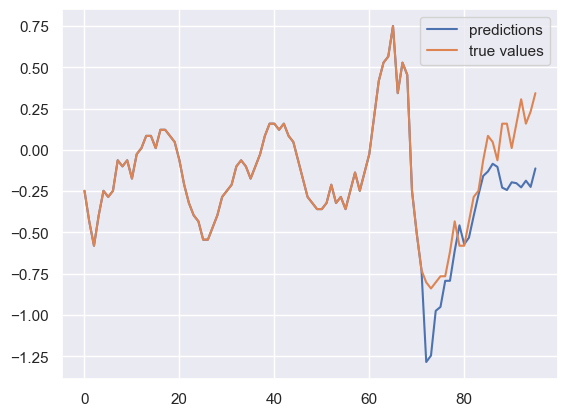

In [174]:
plot_sample_prediction_pm1(continous_24h, simple_rnn_model[0])

1/1 [==============================] - 0s 16ms/step


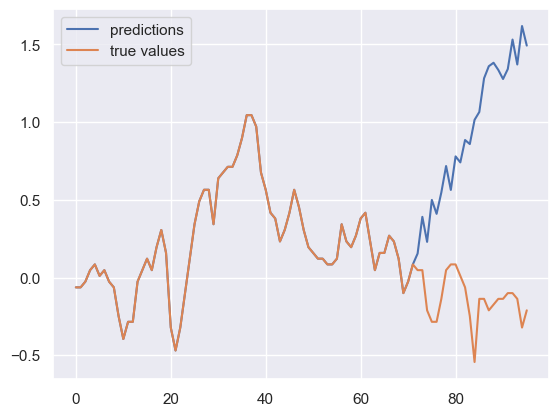

In [175]:
plot_sample_prediction_pm1(continous_24h, simple_rnn_model[0])

1/1 [==============================] - 0s 22ms/step


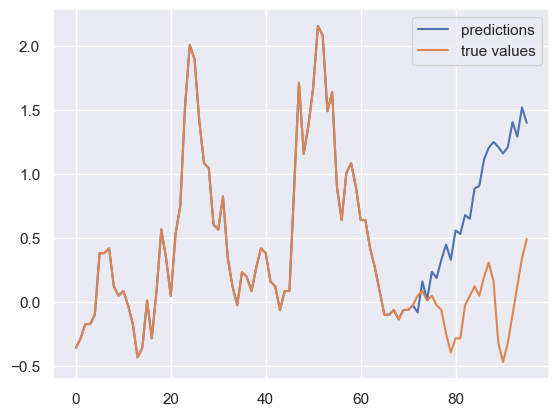

In [176]:
plot_sample_prediction_pm1(continous_24h, simple_rnn_model[0])

In [177]:
def train_LSTM_model(data, 
                        lstm_units=16, 
                        prediction_hours=24,
                        train_epochs=50,
                        opt = 'adam',
                        loss_func='mse',
                        early_st_mon_val='val_loss',
                        early_st_mon_pat=5):
    
    x, y = next(iter(data.train))
       
    model = keras.models.Sequential()
       
    inputs = keras.layers.Input(shape=(x.shape[1], x.shape[2]))
    lstm = keras.layers.LSTM(lstm_units)
    outputs = keras.layers.Dense(prediction_hours)
    
    model.add(inputs)
    model.add(lstm)
    model.add(outputs)
    
    model.compile(optimizer=opt, loss=loss_func) # , metrics=[tf.keras.metrics.MeanSquaredError()]
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_st_mon_val, patience=early_st_mon_pat)
    
    history = model.fit(data.train, epochs=train_epochs, validation_data=data.val) #, callbacks=[early_stopping]
       
    return model, history

In [178]:
lstm_model=train_LSTM_model(continous_24h, lstm_units=8, train_epochs=20)

Epoch 1/20
185/185 [==============================] - 5s 18ms/step - loss: 0.7705 - val_loss: 0.1765
Epoch 2/20
185/185 [==============================] - 3s 18ms/step - loss: 0.4431 - val_loss: 0.1426
Epoch 3/20
185/185 [==============================] - 3s 18ms/step - loss: 0.3838 - val_loss: 0.1369
Epoch 4/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3579 - val_loss: 0.1401
Epoch 5/20
185/185 [==============================] - 3s 18ms/step - loss: 0.3428 - val_loss: 0.1398
Epoch 6/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3350 - val_loss: 0.1383
Epoch 7/20
185/185 [==============================] - 3s 18ms/step - loss: 0.3276 - val_loss: 0.1377
Epoch 8/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3215 - val_loss: 0.1359
Epoch 9/20
185/185 [==============================] - 3s 18ms/step - loss: 0.3185 - val_loss: 0.1347
Epoch 10/20
185/185 [==============================] - 3s 17ms/step - loss: 0.3117 - val_lo

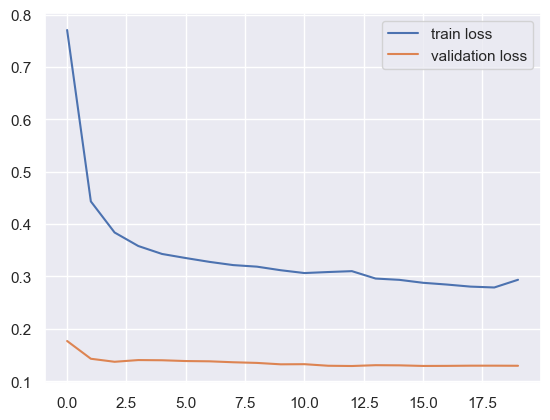

In [179]:
plot_history(lstm_model[1])

1/1 [==============================] - 0s 342ms/step


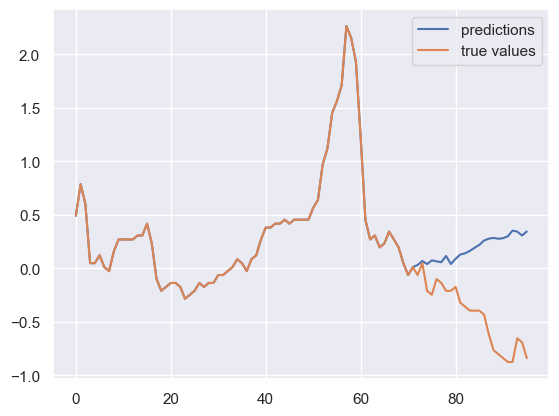

In [180]:
plot_sample_prediction_pm1(continous_24h, lstm_model[0])

1/1 [==============================] - 0s 23ms/step


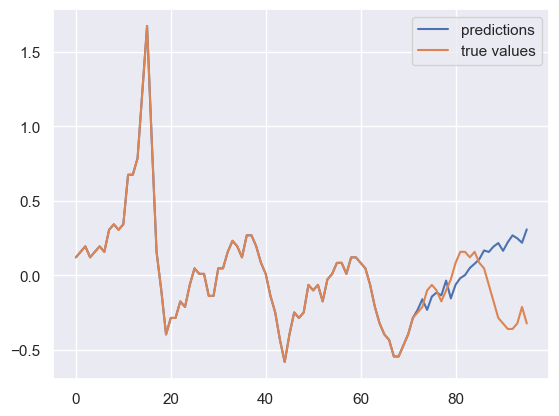

In [181]:
plot_sample_prediction_pm1(continous_24h, lstm_model[0])

1/1 [==============================] - 0s 31ms/step


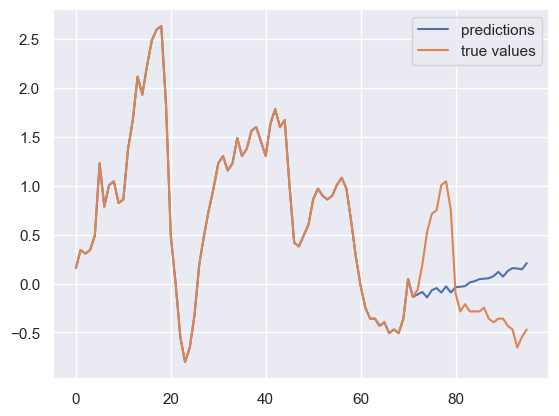

In [182]:
plot_sample_prediction_pm1(continous_24h, lstm_model[0])

In [183]:
def models_metrics(model_dict):
        losses=[]
        for model in model_dict:
            #print(model)
            train_loss = model_dict[model].history['loss'][-1]
            validation_loss = model_dict[model].history['val_loss'][-1]
            print ('Loss on training set for ', model,' is ', round((train_loss),4))
            print('Loss on test set for: ', model,' is ',round((validation_loss),4))
            losses.append(train_loss)
            losses.append(validation_loss)
        return losses

In [184]:
models_metrics({'Simple RNN model':simple_rnn_model[1], 'LSTM model':lstm_model[1]})

Loss on training set for  Simple RNN model  is  0.2747
Loss on test set for:  Simple RNN model  is  0.1305
Loss on training set for  LSTM model  is  0.2935
Loss on test set for:  LSTM model  is  0.1292


[0.2747499644756317,
 0.13053254783153534,
 0.293491005897522,
 0.12923607230186462]

## Conslusion

Based on the resluts we can say that it’s difficult to predict precisely the amount of pm1 particulate matter on certain hour.

Still, the predictions the models generates can be used to speculate the level of air pollution with particulate matter in next 24 h.

Both models in most of the cases can predict the direction of change. In many cases they can also predict the change in trend, but sometimes in delay. There are also cases, when the models predict wrong direction of trend.

The model based on simple RNN cells generates slightly better results with:

    - MSE on training data: 0.2923,
    - MSE on validation data:  0.1375,
    
The model based on LSTM cell gets better results on training set, but worst on validation data, which shows the tendency to overfitting. The results are as follows:
    
    - MSE on training data: 0.2460,
    - MSE on validation data: 0.1392,
   
Despite the miseading predictions the models can generate we think that overall it is worth to use models to predict particulate matter in Cracow.
 
Taking under account slightly better results, and lower tendency to overfitting we would recommend model based on simple RNN cells. 

## Future development

The process of creating a model can be used again with similar data to develop a model for any other airly sensor, located anywhere. We can also use data from sensors form different producers, on condition that we modify the process of data processing.

The developer model can be connected with system of early alerts, so the people can plan in advance and limit their outdoor time in high pollution periods, for example we can plan a remote work for the next day.

The processed data may be also used for solving different issues, like establishing if the current net of sensors provides sufficient coverage of city area.

Another direction can be adding more features to the model, for example information about the location area type (ex. residual, industrial etc.). We can also integrate the model with different sources of information like current weather forecast.

These are few ideas about the future development of the model, but the best scenario would be if we wouldn’t have to use it at all. 